In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


🧠 Backbones recomendados para extração de características biométricas
1. ResNet (ResNet-50 ou ResNet-101)
- ✅ Muito usado em biometria facial e impressão digital
- ✅ Capta padrões profundos e invariantes
- ✅ Fácil de adaptar para extração de embeddings
- 🔧 Pode ser truncado antes da camada de classificação final
2. InceptionV3
- ✅ Excelente para capturar detalhes em imagens com variações de escala e textura
- ✅ Ideal para imagens complexas como focinhos com rugas e manchas
- ✅ Arquitetura leve e eficiente
3. EfficientNet (B0–B7)
- ✅ Ótimo custo-benefício entre desempenho e eficiência computacional
- ✅ Escalável conforme necessidade de precisão
- ✅ Muito usado em aplicações biométricas recentes
4. MobileNetV2
- ✅ Ideal para aplicações embarcadas ou com restrição de hardware (como IoT rural)
- ✅ Rápido e leve, com boa capacidade de extração de características
5. VGG-16 ou VGG-19
- ✅ Simples e eficaz como extrator de características
- ✅ Muito usado em pesquisas de biometria clássica
- ⚠️ Mais pesado em termos de parâmetros, mas fácil de manipular

🧬 Estratégia de uso
- Remova a última camada de classificação (FC) e use a saída da penúltima camada como vetor de características.
- Normalize os vetores (por exemplo, com L2) para facilitar comparações entre vacas.
- Use técnicas como triplet loss ou contrastive loss para treinar o modelo a gerar embeddings únicos por indivíduo.


🧪 Pipeline de Treinamento para Impressão Digital de Focinhos de Vaca

🧠 2. Escolha do Backbone



In [ ]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def build_backbone(model_name='mobilenetv2', input_shape=(224, 224, 3)):
    if model_name == 'mobilenetv2':
        base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'resnet':
        base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'inceptionv3':
        base = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Modelo não suportado")

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda y: tf.math.l2_normalize(y, axis=1))(x)  # Normalização L2
    return Model(inputs=base.input, outputs=x)

🧬 Estratégia de uso
- Remova a última camada de classificação (FC) e use a saída da penúltima camada como vetor de características.
- Normalize os vetores (por exemplo, com L2) para facilitar comparações entre vacas.
- Use técnicas como triplet loss ou contrastive loss para treinar o modelo a gerar embeddings únicos por indivíduo.


📸 3. Preparação dos Dados
- Cada imagem deve estar rotulada com o ID da vaca.
- Para Triplet Loss, você precisa de: anchor, positive, negative.
- Para Contrastive Loss, você precisa de pares: (img1, img2) com rótulo 0 (diferente) ou 1 (mesma vaca).


In [6]:
# função de perda a ser validada
def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:,0,:], y_pred[:,1,:], y_pred[:,2,:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

In [7]:
# função de perda a ser validada
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

🏗️ 5. Montagem do Modelo

In [9]:
embedding_model = build_backbone('mobilenetv2')  # ou 'resnet', 'inceptionv3'

6. Testando a geração de embedding - Mapa de características

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Caminho da imagem no HD
caminho_imagem = r'D:\Users\paulo\PycharmProjects\biometria_bovina_Softsystem_ceia\experimento_paulo\imagens\zenodo\sapi_a\sapi_a_1.jpg'  # Ex: 'C:/dados/focinhos/vaca123.jpg'

# Carregando e pré-processando a imagem
def carregar_imagem_para_input(caminho, tamanho=(224, 224)):
    img = image.load_img(caminho, target_size=tamanho)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Preenchendo o input_anchor
input_anchor_array = carregar_imagem_para_input(caminho_imagem)
embedding_anchor = embedding_model(input_anchor_array)
print(embedding_anchor)

tf.Tensor([[0.03378706 0.02354775 0.03117556 ... 0.03609106 0.03630537 0.01064538]], shape=(1, 1280), dtype=float32)


Para Triplet Loss, você pode criar um modelo com três entradas: ou seja, várias fotos do mesmo animal


In [11]:
from tensorflow.keras.layers import Input

# trocar inputs para imagens reais dos focinhos das vacas
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

merged_output = tf.stack([embedding_anchor, embedding_positive, embedding_negative], axis=1)
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)
triplet_model.compile(optimizer='adam', loss=triplet_loss())

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'Conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d), but
are not present in its tracked objects:
  <tf.Variable 'expanded_conv_depthwise/kernel:0' shape=(3, 3, 32, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'expanded_conv_project/kernel:0' shape=(1, 1, 32, 16) dtype

ValueError: All `inputs` values must be KerasTensors. Received: inputs=[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>] including invalid value KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") of type <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>

Para Contrastive Loss, o modelo pode ter duas entradas e uma saída de distância:


In [ ]:
from tensorflow.keras.layers import Subtract

# duas imagens do focinho do animal
input_1 = Input(shape=(224, 224, 3))
input_2 = Input(shape=(224, 224, 3))

embedding_1 = embedding_model(input_1)
embedding_2 = embedding_model(input_2)

distance = Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=1, keepdims=True))([embedding_1, embedding_2])
contrastive_model = Model(inputs=[input_1, input_2], outputs=distance)
contrastive_model.compile(optimizer='adam', loss=contrastive_loss())

📊 6. Treinamento
Para treinamento de uma rede neural, de um possível dataset anotado para geração de impressão digital

In [ ]:
# Para triplet_model
triplet_model.fit([anchors, positives, negatives], np.zeros(len(anchors)), epochs=10)

# Para contrastive_model
contrastive_model.fit([img1, img2], labels, epochs=10)

🧬 Visualização de Embedding com Matplotlib


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


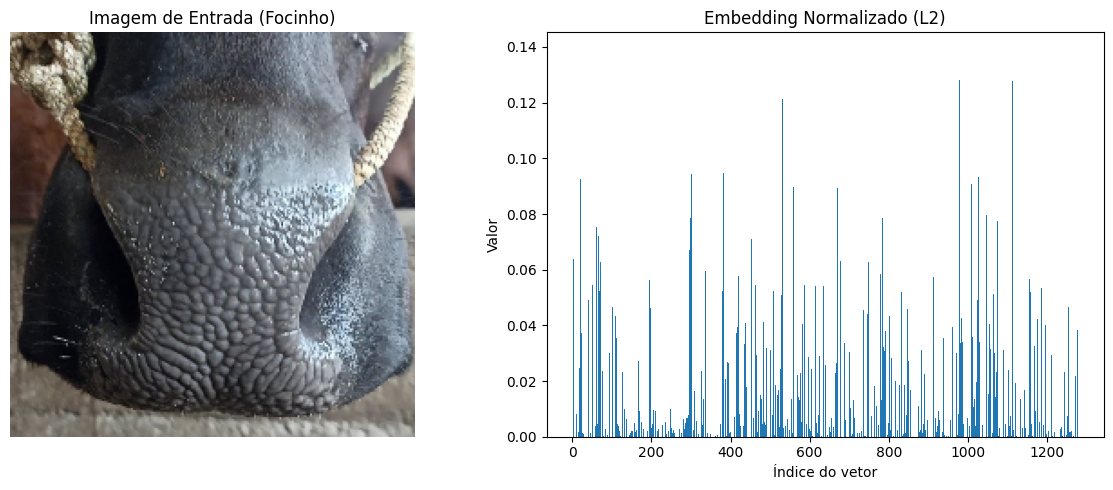

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Carregando o modelo backbone
embedding_model = build_backbone('mobilenetv2')  # ou 'resnet', 'inceptionv3'

# Carregando e pré-processando a imagem
img_path = r'D:\Users\paulo\PycharmProjects\biometria_bovina_Softsystem_ceia\experimento_paulo\imagens\zenodo\sapi_a\sapi_a_5.jpg'  # substitua pelo caminho da sua imagem
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Gerando o embedding
embedding = embedding_model.predict(img_array)[0]  # vetor 1D

# 🔍 Visualização
plt.figure(figsize=(12, 5))

# Imagem original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagem de Entrada (Focinho)")
plt.axis('off')

# Embedding como gráfico de barras
plt.subplot(1, 2, 2)
plt.bar(range(len(embedding)), embedding)
plt.title("Embedding Normalizado (L2)")
plt.xlabel("Índice do vetor")
plt.ylabel("Valor")
plt.tight_layout()
plt.show()

🧬 Visualização de Embedding com Matplotlib

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


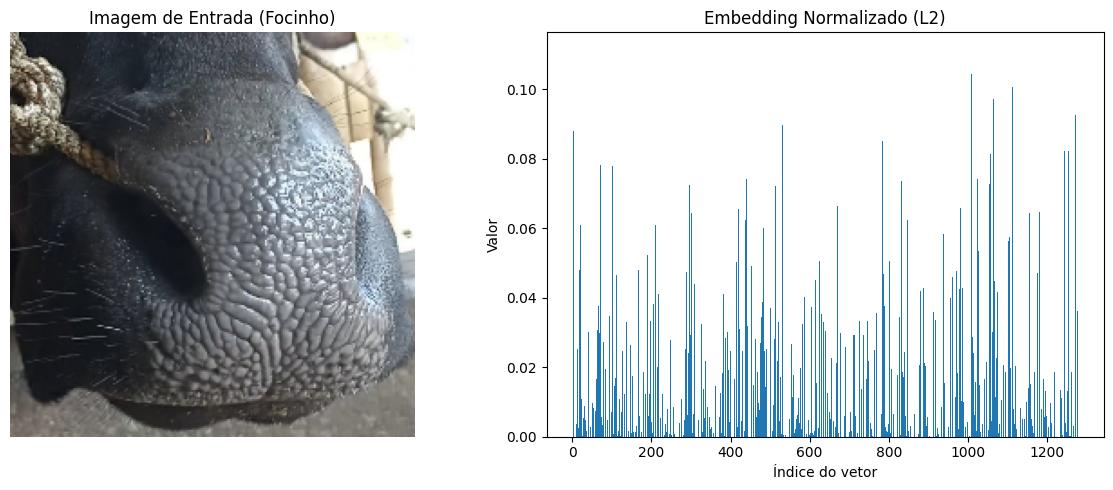

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Carregando o modelo backbone
embedding_model = build_backbone('mobilenetv2')  # ou 'resnet', 'inceptionv3'

# Carregando e pré-processando a imagem
img_path = r'D:\Users\paulo\PycharmProjects\biometria_bovina_Softsystem_ceia\experimento_paulo\imagens\zenodo\sapi_a\sapi_a_1.jpg'  # substitua pelo caminho da sua imagem
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Gerando o embedding
embedding = embedding_model.predict(img_array)[0]  # vetor 1D

# 🔍 Visualização
plt.figure(figsize=(12, 5))

# Imagem original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagem de Entrada (Focinho)")
plt.axis('off')

# Embedding como gráfico de barras
plt.subplot(1, 2, 2)
plt.bar(range(len(embedding)), embedding)
plt.title("Embedding Normalizado (L2)")
plt.xlabel("Índice do vetor")
plt.ylabel("Valor")
plt.tight_layout()
plt.show()

Etapa 1: Cadastro da vaca no sistema
🔹 Fluxo de cadastro
- Captura da imagem do focinho com boa iluminação e resolução.
- Geração do embedding usando o modelo backbone (MobileNetV2, ResNet, etc.).
- Normalização L2 do vetor para garantir comparabilidade.
- Armazenamento no banco de dados:
- ID da vaca (ex: vaca_001)
- Embedding (vetor 1D, geralmente 128 ou 512 dimensões)
- Metadados (nome, idade, fazenda, etc.)
💾 Exemplo de estrutura no banco
{
  "vaca_001": {
    "embedding": [0.12, -0.03, ..., 0.07],
    "nome": "Estrela",
    "fazenda": "Fazenda Boa Vista",
    "data_cadastro": "2025-10-01"
  }
}



📸 Etapa 2: Identificação em tempo real com câmera
🔹 Fluxo de reconhecimento
- Captura da imagem ao vivo da vaca com a câmera.
- Pré-processamento da imagem (redimensionamento, normalização).
- Geração do embedding atual com o mesmo modelo backbone.
- Comparação com o banco de dados:
- Calcular distância euclidiana ou cosine similarity entre o embedding atual e todos os embeddings cadastrados.
- Selecionar o ID da vaca com menor distância (mais parecido).
- Definir um limiar de aceitação (ex: distância < 0.5) para garantir confiabilidade.
📐 Exemplo de código para comparação
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def identificar_vaca(embedding_atual, banco_embeddings, limiar=0.5):
    melhor_id = None
    melhor_similaridade = -1

    for id_vaca, dados in banco_embeddings.items():
        emb_cadastrado = np.array(dados['embedding']).reshape(1, -1)
        emb_atual = embedding_atual.reshape(1, -1)
        sim = cosine_similarity(emb_cadastrado, emb_atual)[0][0]
        if sim > melhor_similaridade and sim >= limiar:
            melhor_similaridade = sim
            melhor_id = id_vaca

    return melhor_id, melhor_similaridade



🛡️ Etapa 3: Garantia de consistência e segurança
✅ Boas práticas
- Usar sempre o mesmo modelo backbone para cadastro e reconhecimento.
- Evitar múltiplas imagens por vaca com variações extremas (chuva, lama, sombra).
- Cadastrar múltiplos embeddings por vaca (média ou conjunto) para aumentar robustez.
- Aplicar PCA ou t-SNE para visualizar clusters e detectar duplicações ou erros.
- Auditar embeddings duplicados ou muito próximos para evitar falsos positivos.

🧠 Etapa 4: Evolução com aprendizado contínuo
- Reforçar o embedding da vaca com novas imagens ao longo do tempo.
- Usar métodos de atualização incremental para refinar o vetor biométrico.
- Implementar verificação humana assistida nos casos de baixa confiança.



## PRIMEIRO TESTE

In [18]:
import os
import pandas as pd


def criar_dataframe_imagens(diretorio_base):
    # Lista para armazenar os dados
    dados = []

    # Percorrendo as pastas e arquivos no diretório base
    for pasta, subpastas, arquivos in os.walk(diretorio_base):
        for arquivo in arquivos:
            # Verifica se é uma imagem (por exemplo: arquivos .jpg ou .png)
            if arquivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                caminho_completo = os.path.join(pasta, arquivo)  # Caminho completo do arquivo
                nome_pasta = os.path.basename(pasta)  # Nome da pasta atual
                dados.append({'id': arquivo, 'endereco': caminho_completo, 'pasta': nome_pasta})

    # Criando o DataFrame
    dataframe = pd.DataFrame(dados)
    return dataframe


# Diretório base onde estão as imagens
diretorio_base = r'D:\Users\paulo\PycharmProjects\biometria_bovina_Softsystem_ceia\experimento_paulo\imagens\zenodo'  # Altere para o caminho desejado

# Gerando o DataFrame
df = criar_dataframe_imagens(diretorio_base)

# Exibindo o DataFrame
print(df)


                id                                           endereco   pasta
0     sapi_a_1.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a
1     sapi_a_2.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a
2     sapi_a_3.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a
3     sapi_a_4.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a
4     sapi_a_5.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a
..             ...                                                ...     ...
145   sapi_z_1.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_z
146  sapi_z_12.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_z
147   sapi_z_6.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_z
148   sapi_z_7.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_z
149   sapi_z_8.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_z

[150 rows x 3 columns]


In [21]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


# Função para criar o DataFrame com imagens
def criar_dataframe_imagens(diretorio_base):
    dados = []

    for pasta, subpastas, arquivos in os.walk(diretorio_base):
        for arquivo in arquivos:
            if arquivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                caminho_completo = os.path.join(pasta, arquivo)
                nome_pasta = os.path.basename(pasta)
                dados.append({'id': arquivo, 'endereco': caminho_completo, 'pasta': nome_pasta})

    return pd.DataFrame(dados)


# Função para gerar embeddings para cada imagem
def gerar_embeddings(dataframe, modelo, tamanho_imagem=(224, 224)):
    embeddings = []

    for i, row in dataframe.iterrows():
        img_path = row['endereco']  # Caminho da imagem
        try:
            # Carregando e processando a imagem
            img = image.load_img(img_path, target_size=tamanho_imagem)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Gerando embedding
            embedding = modelo.predict(img_array)[0]  # Vetor 1D
            embeddings.append(embedding)
        except Exception as e:
            print(f"Erro ao processar a imagem {img_path}: {e}")
            embeddings.append(None)  # Para casos de erro, adiciona None como valor padrão

    dataframe['embedding'] = embeddings  # Adiciona os embeddings ao DataFrame
    return dataframe


# Diretório base das imagens
diretorio_base = r'D:\Users\paulo\PycharmProjects\biometria_bovina_Softsystem_ceia\experimento_paulo\imagens\zenodo'  # Substitua pelo caminho correto


# Criando o modelo de embedding
def build_backbone_MobileNetV2():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = tf.math.l2_normalize(x, axis=1)
    return Model(inputs=base_model.input, outputs=x)

embedding_model = build_backbone('mobilenetv2')
# Carregar o modelo backbone
# embedding_model = build_backbone_MobileNetV2()

# Criação do DataFrame inicial
df = criar_dataframe_imagens(diretorio_base)

# Adicionando embeddings ao DataFrame
df_com_embeddings = gerar_embeddings(df, embedding_model)

# Exibindo o DataFrame final com os embeddings
print(df_com_embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

In [23]:
print(df_com_embeddings.head(5))

             id                                           endereco   pasta  \
0  sapi_a_1.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a   
1  sapi_a_2.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a   
2  sapi_a_3.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a   
3  sapi_a_4.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a   
4  sapi_a_5.jpg  D:\Users\paulo\PycharmProjects\biometria_bovin...  sapi_a   

                                           embedding  
0  [0.03378706, 0.02354775, 0.031175578, 0.087844...  
1  [0.07223866, 0.006499065, 0.013492273, 0.11353...  
2  [0.0, 0.02453254, 0.0043398524, 0.0478171, 0.0...  
3  [0.0125527, 0.003889759, 0.0, 0.077830866, 0.0...  
4  [0.018804668, 0.0025972964, 0.006531042, 0.063...  


In [77]:
from sklearn.metrics.pairwise import cosine_similarity

def identificar_vaca(id_vaca_local, embedding_atual, banco_embeddings, limiar=0.7):
    melhor_id = None
    melhor_similaridade = -1

    for id_vaca, dados in banco_embeddings.iterrows():
        if dados['id'] != id_vaca_local:
            emb_cadastrado = np.array(dados['embedding']).reshape(1, -1)
            emb_atual = embedding_atual.reshape(1, -1)
            sim = cosine_similarity(emb_cadastrado, emb_atual)[0][0]
            if sim > melhor_similaridade and sim >= limiar:
                melhor_similaridade = sim
                melhor_id = id_vaca
                print("a vaca de id ", id_vaca_local, " tem a similaridade de ", sim, " com a vaca de id ", dados['id'], "")

    return melhor_id, melhor_similaridade

In [80]:
for id_vaca_local, dados_local in df_com_embeddings.iterrows():
    melhor_id, melhor_similaridade = identificar_vaca(dados_local['id'], dados_local['embedding'], df_com_embeddings)
    print(f"ID da vaca: {id_vaca_local}, ID do melhor embedding: {melhor_id}, Similaridade: {melhor_similaridade}")
    break  # Interrompe o loop após a primeira interação


a vaca de id  sapi_a_1.jpg  tem a similaridade de  0.7404644  com a vaca de id  sapi_a_2.jpg 
a vaca de id  sapi_a_1.jpg  tem a similaridade de  0.81520545  com a vaca de id  sapi_a_4.jpg 
ID da vaca: 0, ID do melhor embedding: 3, Similaridade: 0.815205454826355
